In [132]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import requests
import os
from dotenv import load_dotenv

# Handle .env path for both scripts and notebooks
try:
    # For .py scripts
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    # For Jupyter Notebooks (__file__ not defined)
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Load .env from project root
dotenv_path = os.path.join(project_root, '.env')
load_dotenv(dotenv_path)

# Access environment variables
model_target = os.getenv("MODEL_TARGET")
credentials_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

# Print to check if they are loaded correctly
print(f"Model Target: {model_target}")
print(f"Google Credentials Path: {credentials_path}")


Model Target: local
Google Credentials Path: /path/to/your/service-account-file.json


## Import of Dataset from BigQuery

In [127]:
# Path to your Google Cloud service account key file
key_path = credentials_path

# Create credentials and initialize the BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project="edhecbusinessdatamanagement")

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/service-account-file.json'

In [ ]:

query = """
    SELECT * 
    FROM `edhec-business-manageme.luxurydata2502.price-monitoring-2022`
    WHERE Brand = 'Cartier'
"""

# Run the query and load results into a Pandas DataFrame
df = client.query(query).to_dataframe()

# Display the first rows of the dataframe
print(df.head())


/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


     uid    brand                                                url   price  \
0  10239  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...   43900   
1  10240  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...  880000   
2  10241  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...  905000   
3  10242  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...   22000   
4  10243  Cartier  https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...   53000   

  currency                                          image_url  \
0      CNY  https://www.cartier.com/content/dam/rcq/car/75...   
1      CNY  https://www.cartier.com/content/dam/rcq/car/16...   
2      CNY  https://www.cartier.cn/content/dam/rcq/car/19/...   
3      CNY  https://www.cartier.com/content/dam/rcq/car/59...   
4      CNY  https://www.cartier.com/content/dam/rcq/car/10...   

         collection reference_code country life_span_date       life_span  \
0       BALLON BLEU       WSBB0007    None     2020

## Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181404 entries, 0 to 181403
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   uid                   181404 non-null  Int64         
 1   brand                 181404 non-null  object        
 2   url                   181404 non-null  object        
 3   price                 157674 non-null  Int64         
 4   currency              181404 non-null  object        
 5   image_url             159886 non-null  object        
 6   collection            172770 non-null  object        
 7   reference_code        181374 non-null  object        
 8   country               0 non-null       object        
 9   life_span_date        181404 non-null  datetime64[us]
 10  life_span             181404 non-null  object        
 11  price_before          114852 non-null  float64       
 12  price_difference      181404 non-null  Int64         
 13 

In [ ]:
df = df.drop(["country","is_new", "image_url"], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181404 entries, 0 to 181403
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   uid                   181404 non-null  Int64         
 1   brand                 181404 non-null  object        
 2   url                   181404 non-null  object        
 3   price                 157674 non-null  Int64         
 4   currency              181404 non-null  object        
 5   collection            172770 non-null  object        
 6   reference_code        181374 non-null  object        
 7   life_span_date        181404 non-null  datetime64[us]
 8   life_span             181404 non-null  object        
 9   price_before          114852 non-null  float64       
 10  price_difference      181404 non-null  Int64         
 11  price_percent_change  181404 non-null  float64       
 12  price_changed         181404 non-null  float64       
dtyp

In [ ]:
df = df.dropna(subset=['price'])
df = df.dropna(subset=['collection'])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149355 entries, 0 to 181252
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   uid                   149355 non-null  Int64         
 1   brand                 149355 non-null  object        
 2   url                   149355 non-null  object        
 3   price                 149355 non-null  Int64         
 4   currency              149355 non-null  object        
 5   collection            149355 non-null  object        
 6   reference_code        149354 non-null  object        
 7   life_span_date        149355 non-null  datetime64[us]
 8   life_span             149355 non-null  object        
 9   price_before          108888 non-null  float64       
 10  price_difference      149355 non-null  Int64         
 11  price_percent_change  149355 non-null  float64       
 12  price_changed         149355 non-null  float64       
dtypes: I

In [ ]:
df.head()

,uid,brand,url,price,currency,collection,reference_code,life_span_date,life_span,price_before,price_difference,price_percent_change,price_changed
0,10239,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,43900,CNY,BALLON BLEU,WSBB0007,2020-08-29,Q4 August 2020,NaN,0,0.0,0.0
1,10240,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,880000,CNY,ROTONDE,WHRO0041,2020-08-29,Q4 August 2020,NaN,0,0.0,0.0
2,10241,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,905000,CNY,TANK,WJBJ0005,2020-08-29,Q4 August 2020,NaN,0,0.0,0.0
3,10242,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,22000,CNY,RONDE SOLO WATCH,W6701005,2020-08-29,Q4 August 2020,NaN,0,0.0,0.0
4,10243,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,53000,CNY,TANK,W5330003,2020-08-29,Q4 August 2020,NaN,0,0.0,0.0


In [ ]:
df[df['price_before'].notna()].head()


,uid,brand,url,price,currency,collection,reference_code,life_span_date,life_span,price_before,price_difference,price_percent_change,price_changed
3963,30103,Cartier,https://www.cartier.ch/fr-ch/collections/montr...,69000,CHF,TANK,HPI00327,2020-09-29,Q4 September 2020,67500.0,1500,2.22,1.0
3964,30104,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,539500,CNY,TANK,HPI00327,2020-09-29,Q4 September 2020,539500.0,0,0.00,0.0
3965,30105,Cartier,https://www.cartier.fr/fr/collections/montres/...,71500,EUR,TANK,HPI00327,2020-09-29,Q4 September 2020,68500.0,3000,4.38,1.0
3966,30106,Cartier,https://www.cartier.co.uk/en-gb/collections/wa...,65000,GBP,TANK,HPI00327,2020-09-29,Q4 September 2020,61000.0,4000,6.56,1.0
3967,30107,Cartier,https://www.cartier.hk/en-hk/collections/watch...,530000,HKD,TANK,HPI00327,2020-09-29,Q4 September 2020,505000.0,25000,4.95,1.0


In [ ]:
# Not many rows have actual information about price difference
df["price_difference"].count() - df["price_difference"][df["price_difference"] == 0].count()

12285

In [ ]:
# Not many rows have actual information about price change 
df["price_changed"].count() - df["price_changed"][df["price_changed"] == 0].count()

12285

In [ ]:
# I remove these columns

df = df.drop(["price_difference", "price_percent_change", "price_changed", "price_before"], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149355 entries, 0 to 181252
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   uid             149355 non-null  Int64         
 1   brand           149355 non-null  object        
 2   url             149355 non-null  object        
 3   price           149355 non-null  Int64         
 4   currency        149355 non-null  object        
 5   collection      149355 non-null  object        
 6   reference_code  149354 non-null  object        
 7   life_span_date  149355 non-null  datetime64[us]
 8   life_span       149355 non-null  object        
dtypes: Int64(2), datetime64[us](1), object(6)
memory usage: 11.7+ MB


# Preprocessing: Same Exchange rate for all products

In [ ]:
# API URL for exchange rates (USD as base currency)
url = 'https://v6.exchangerate-api.com/v6/4eb043dba172cec94fe70b22/latest/EUR'

# Making the request
response = requests.get(url)
data = response.json()

# Extract the conversion rates dictionary
conversion_rates = data["conversion_rates"]

# Convert to DataFrame
cr = pd.DataFrame(list(conversion_rates.items()), columns=["Currency", "Exchange Rate"])

In [ ]:
# Merge df1 (orders) with cr (exchange rates) based on currency
df = df.merge(cr, left_on="currency", right_on="Currency", how="left")

# Convert price using the exchange rate
df["price_EUR"] = df["price"] / df["Exchange Rate"]

# Drop unnecessary columns
df = df.drop(columns=["Exchange Rate", "Currency"])

In [ ]:
df.head(100)

,uid,brand,url,price,currency,collection,reference_code,life_span_date,life_span,price_EUR
0,10239,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,43900,CNY,BALLON BLEU,WSBB0007,2020-08-29,Q4 August 2020,5772.214479
1,10240,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,880000,CNY,ROTONDE,WHRO0041,2020-08-29,Q4 August 2020,115707.260631
2,10241,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,905000,CNY,TANK,WJBJ0005,2020-08-29,Q4 August 2020,118994.398717
3,10242,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,22000,CNY,RONDE SOLO WATCH,W6701005,2020-08-29,Q4 August 2020,2892.681516
4,10243,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,53000,CNY,TANK,W5330003,2020-08-29,Q4 August 2020,6968.732743
...,...,...,...,...,...,...,...,...,...,...
95,10337,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,68000,CNY,SANTOS CHRONOGRAPH WATCH,WSSA0017,2020-08-29,Q4 August 2020,8941.015594
96,10338,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,49000,CNY,DRIVE WATCH,WSNM0015,2020-08-29,Q4 August 2020,6442.790649
97,10339,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,135000,CNY,CLÉ,WJCL0047,2020-08-29,Q4 August 2020,17750.545665
98,10340,Cartier,https://www.cartier.cn/zh-cn/%E7%B3%BB%E5%88%9...,232000,CNY,BALLON BLEU WATCH,WE902026,2020-08-29,Q4 August 2020,30504.641439


In [ ]:
df_monthly_averages = df.groupby("life_span_date")["price_EUR"].median().reset_index()

df_monthly_averages.head()



,life_span_date,price_EUR
0,2020-08-29,20751.071895
1,2020-09-24,6926.766252
2,2020-09-29,22088.357558
3,2020-10-28,20300.910067
4,2020-11-27,20514.058163


In [ ]:
import pandas as pd

# Sort by date to ensure proper moving average calculation
df_monthly_averages = df_monthly_averages.sort_values(by="life_span_date")

# Step 1: Compute the moving average (window size can be adjusted)
window_size = 3
df_monthly_averages["moving_avg"] = df_monthly_averages["price_EUR"].rolling(window=window_size, min_periods=1, center=True).mean()

# Step 2: Replace values below 7500 with the moving average
df_monthly_averages["price_EUR"] = df_monthly_averages.apply(
    lambda row: row["moving_avg"] if row["price_EUR"] < 7500 else row["price_EUR"],
    axis=1
)

# Step 3: Drop the temporary moving average column
df_monthly_averages.drop(columns=["moving_avg"], inplace=True)

# Display the updated DataFrame
df_monthly_averages.head()


,life_span_date,price_EUR
0,2020-08-29,20751.071895
1,2020-09-24,16588.731902
2,2020-09-29,22088.357558
3,2020-10-28,20300.910067
4,2020-11-27,20514.058163


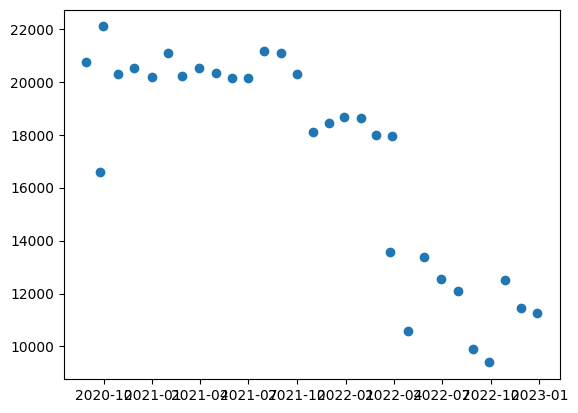

In [ ]:
plt.scatter(df_monthly_averages["life_span_date"], df_monthly_averages["price_EUR"])

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Ensure the date column is datetime and set as index
df_monthly_averages["life_span_date"] = pd.to_datetime(df_monthly_averages["life_span_date"])
df_monthly_averages.set_index("life_span_date", inplace=True)

# ADF test
result = adfuller(df_monthly_averages["price_EUR"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

# Interpretation: If p-value < 0.05, data is stationary; otherwise, differencing is needed


ADF Statistic: -0.004383282776544413
p-value: 0.9581680870102462
Critical Value (1%): -3.6790595944893187
Critical Value (5%): -2.9678817237279103
Critical Value (10%): -2.6231583472057074


ADF Statistic (Differenced): -11.725432527513375
p-value (Differenced): 1.381243352754128e-21


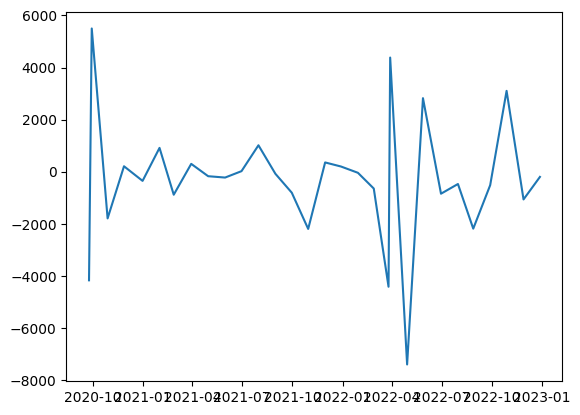

In [ ]:
# Differencing the data
df_monthly_averages["price_diff"] = df_monthly_averages["price_EUR"].diff().dropna()

# Re-run ADF test on differenced data
result_diff = adfuller(df_monthly_averages["price_diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]}")
print(f"p-value (Differenced): {result_diff[1]}")

plt.plot(df_monthly_averages["price_diff"]);

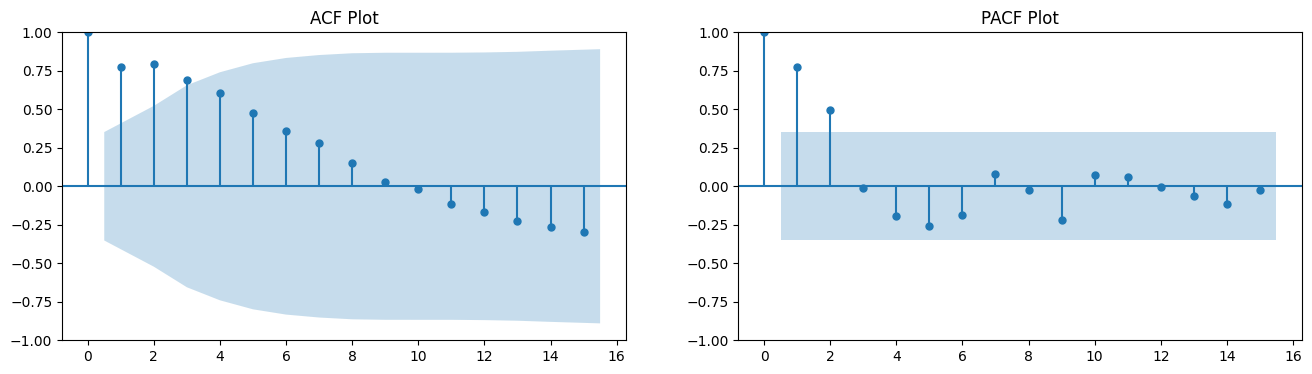

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot (to find MA(q))
plot_acf(df_monthly_averages["price_EUR"].dropna(), ax=axes[0])
axes[0].set_title('ACF Plot')

# PACF plot (to find AR(p))
plot_pacf(df_monthly_averages["price_EUR"].dropna(), ax=axes[1])
axes[1].set_title('PACF Plot')

plt.show()


In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1), AR(2), and AR(3) models
model_ar1 = AutoReg(df_monthly_averages["price_EUR"], lags=1).fit()
model_ar2 = AutoReg(df_monthly_averages["price_EUR"], lags=2).fit()
model_ar3 = AutoReg(df_monthly_averages["price_EUR"], lags=3).fit()

# Extract BIC values
bic_values = {
    "AR(1)": model_ar1.bic,
    "AR(2)": model_ar2.bic,
    "AR(3)": model_ar3.bic
}

# Display BIC scores
for model, bic in bic_values.items():
    print(f"{model} BIC: {bic}")

# Determine model with the lowest BIC
best_model = min(bic_values, key=bic_values.get)
print(f"\n✅ The model with the lowest BIC is: {best_model}")


AR(1) BIC: 560.4628805562247
AR(2) BIC: 529.5289247178617
AR(3) BIC: 511.34247557938005

✅ The model with the lowest BIC is: AR(3)


/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Forecast the next 12 periods (adjust as needed)
n_periods = 12
forecast = model_ar3.predict(
    start=len(df_monthly_averages),
    end=len(df_monthly_averages) + n_periods - 1,
    dynamic=False
)

# Create a future date range for the forecast
last_date = df_monthly_averages.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_periods + 1, freq='M')[1:]

# Combine forecast with dates into a DataFrame
forecast_df = pd.DataFrame({'forecast': forecast.values}, index=future_dates)
forecast_df.head()


/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


,forecast
2023-01-31,10954.153029
2023-02-28,10615.653994
2023-03-31,10316.997690
2023-04-30,9998.311343
2023-05-31,9686.914053


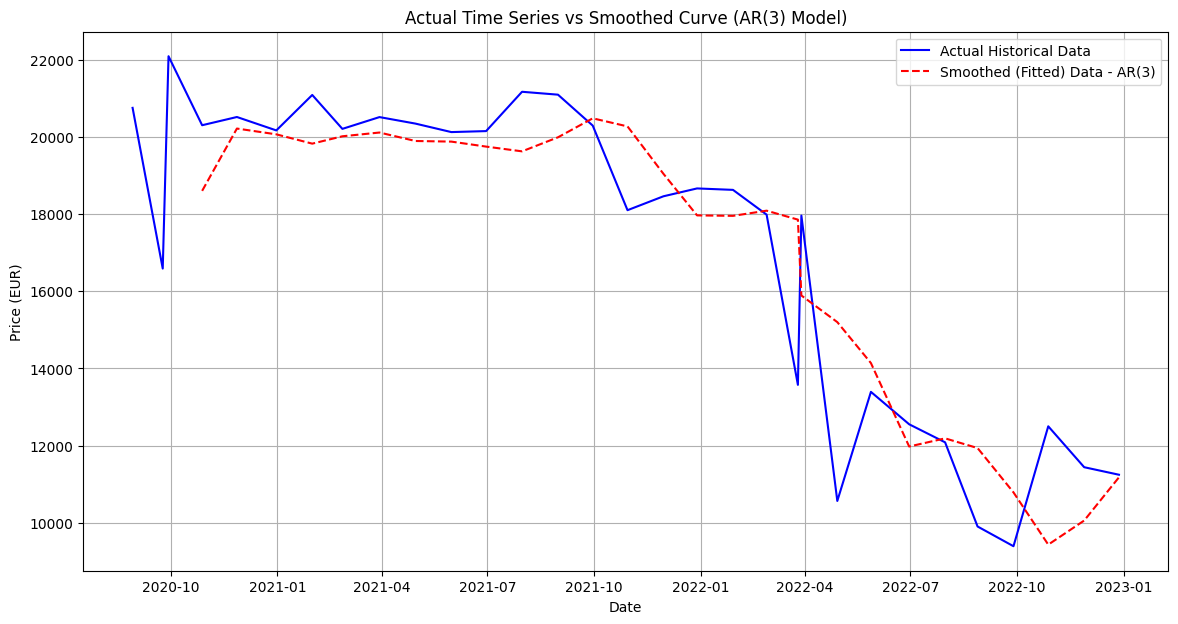

In [ ]:
import matplotlib.pyplot as plt

# Get fitted values (smoothed series) for the historical period
fitted_values = model_ar3.fittedvalues

# Plot actual vs smoothed (fitted) data
plt.figure(figsize=(14, 7))
plt.plot(df_monthly_averages.index, df_monthly_averages["price_EUR"], label="Actual Historical Data", color="blue")
plt.plot(fitted_values.index, fitted_values.values, label="Smoothed (Fitted) Data - AR(3)", color="red", linestyle='--')

plt.title("Actual Time Series vs Smoothed Curve (AR(3) Model)")
plt.xlabel("Date")
plt.ylabel("Price (EUR)")
plt.legend()
plt.grid(True)
plt.show()


/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/maltestaab/.pyenv/versions/3.8.12/envs/chanelenv/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


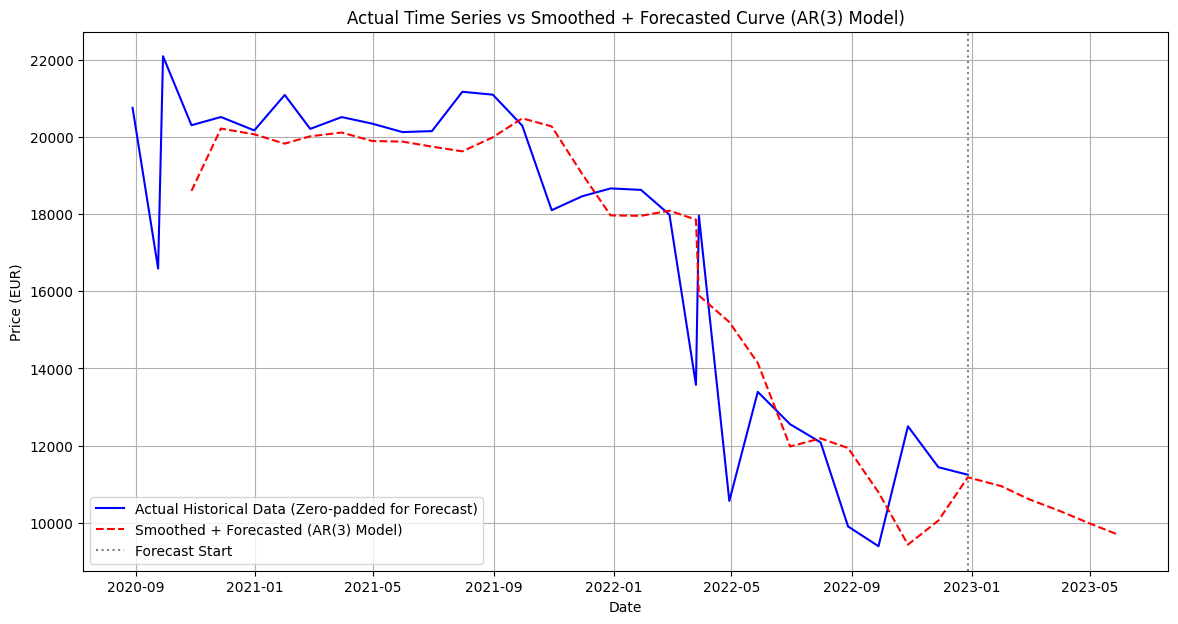

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get fitted values (smoothed series) for the historical period
# Fitted values start after the lag period, so we align them properly
fitted_values = model_ar3.fittedvalues
fitted_full = pd.Series(index=df_monthly_averages.index, dtype=float)
fitted_full[fitted_values.index] = fitted_values

# Step 2: Forecast the next 12 periods
n_periods = 5
forecast = model_ar3.predict(
    start=len(df_monthly_averages),
    end=len(df_monthly_averages) + n_periods - 1,
    dynamic=False
)

# Step 3: Create future dates for the forecast period
last_date = df_monthly_averages.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='M')

# Step 4: Adjust actual series by appending zeros for the forecast period
actual_extended = pd.concat([
    df_monthly_averages["price_EUR"],
    pd.Series(["NaN"] * n_periods, index=future_dates)
])

# Step 5: Combine smoothed (fitted) historical values and forecast
smoothed_forecast_series = pd.concat([fitted_full, forecast])

# Step 6: Ensure identical index lengths and alignment
smoothed_forecast_series.index = actual_extended.index  # Now both have exact same length

# Step 7: Plot actual, smoothed, and forecasted data
plt.figure(figsize=(14, 7))
plt.plot(actual_extended.index, actual_extended.values, label="Actual Historical Data (Zero-padded for Forecast)", color="blue")
plt.plot(smoothed_forecast_series.index, smoothed_forecast_series.values, label="Smoothed + Forecasted (AR(3) Model)", color="red", linestyle='--')

plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')
plt.title("Actual Time Series vs Smoothed + Forecasted Curve (AR(3) Model)")
plt.xlabel("Date")
plt.ylabel("Price (EUR)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.cloud import bigquery
import pandas as pd
import os

# Define SQL query
query = """
SELECT *
FROM `edhecbusinessdatamanagement.cartier_us.cartier_us`
WHERE brand = 'Cartier';
"""

# Run query and store results in a DataFrame
query_job = client.query(query)
df_2025 = query_job.result().to_dataframe()

# Preview the DataFrame
print(df_2025.head())


Forbidden: 403 Access Denied: Table edhecbusinessdatamanagement:cartier_us.cartier_us: User does not have permission to query table edhecbusinessdatamanagement:cartier_us.cartier_us, or perhaps it does not exist.; reason: accessDenied, message: Access Denied: Table edhecbusinessdatamanagement:cartier_us.cartier_us: User does not have permission to query table edhecbusinessdatamanagement:cartier_us.cartier_us, or perhaps it does not exist.

Location: US
Job ID: d66de351-db90-490a-b787-d6f6b6405314
